<a href="https://colab.research.google.com/github/ashikshafi08/Learning_Tensorflow/blob/main/Tensorflow_Tree_Seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install aicrowd-cli

%load_ext aicrowd.magic
%aicrowd login

# Downloading the Dataset
!rm -rf data
!mkdir data
%aicrowd ds dl -c tree-segmentation -o data

Please login here: https://api.aicrowd.com/auth/JgNqgYthSjxdvPWVPK8tDEvSbUZ5A9IQ1hp9y6_zF_Y
API Key valid
Saved API Key successfully!


test.zip:   0%|          | 0.00/316M [00:00<?, ?B/s]

train.zip:   0%|          | 0.00/402M [00:00<?, ?B/s]

In [2]:
!unzip data/train.zip -d data/train > /dev/null
!unzip data/test.zip -d data/test > /dev/null

In [1]:
# Importing the things we neeed 
import tensorflow as tf 
import os 
import numpy as np 
import matplotlib.pyplot as plt 
import cv2

In [2]:
# Getting the input and output images dir 

input_dir = 'data/train/image/'
output_dir = 'data/train/segmentation/'
img_size = (224 , 224)
num_classes = 1
batch_size = 32 

In [3]:
input_img_paths = sorted(
    os.path.join(input_dir , fname)
    for fname in os.listdir(input_dir)
    if fname.endswith('.jpg')
)

target_img_paths = sorted(
    os.path.join(output_dir , fname)
    for fname in os.listdir(output_dir)
    if fname.endswith('.png') and not fname.startswith('.')
)

In [4]:
print(f'Number of samples in the input: {len(input_img_paths)}')
print(f'Number of samples in the output: {len(target_img_paths)}')

Number of samples in the input: 5000
Number of samples in the output: 5000


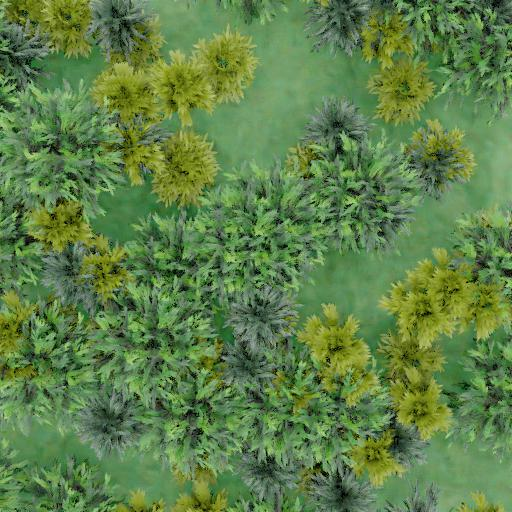

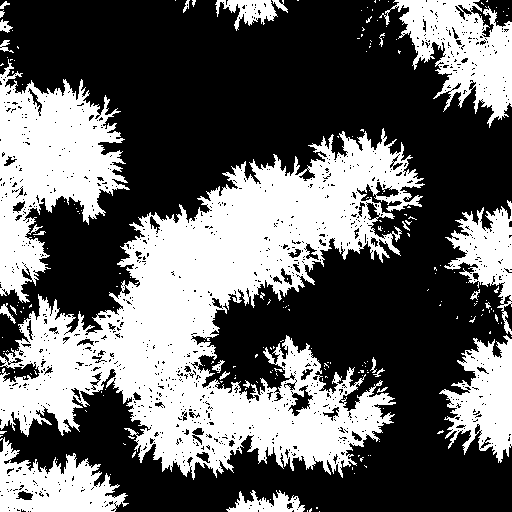

In [5]:
# Displaying one input image and the corresponding mask
from PIL import ImageOps
from IPython.display import Image
import PIL
from tensorflow.keras.preprocessing.image import load_img

# Displaying the input image 
display(Image(input_img_paths[8]))

# Displaying the auto-contrast version of the target 
#img = PIL.ImageOps.autocontrast(load_img(target_img_paths[8]))
display(load_img(target_img_paths[8]))

In [6]:
from tensorflow.keras import layers
from tensorflow import keras


def get_model(img_size, num_classes = 3):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(3, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [7]:
# Splitting our images into train and validation set 
import random 
val_samples = 800 

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]

val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Checking the length
len(train_input_img_paths) , len(train_target_img_paths) , len(val_input_img_paths) , len(val_target_img_paths)

(4200, 4200, 800, 800)

In [8]:
# # Preprocess function 
# def preprocess_func(fnames):
#   image_string = tf.io.read_file(fnames)
#   image_decoded = tf.io.decode_image(image_string , channels = 3)
#   #img = tf.image.resize(image_decoded , size = [image_shape , image_shape])
#   return tf.cast(image_decoded , tf.float32) / 255.

# # Mapping preprocess function to our train data 
# input_dataset = input_dataset.map(map_func= preprocess_func , num_parallel_calls= tf.data.AUTOTUNE)
# output_dataset = output_dataset.map(map_func=preprocess_func , num_parallel_calls= tf.data.AUTOTUNE)

# input_dataset , output_dataset

In [9]:
# Loading in the images 
train_input_imgs = tf.keras.preprocessing.image_dataset_from_directory(directory='data/train/image/' , 
                                                                       labels= None, 
                                                                       image_size = (224 , 224) , 
                                                                       validation_split = 0.2 , 
                                                                       subset = 'training' , 
                                                                       seed = 42)
train_target_imgs = tf.keras.preprocessing.image_dataset_from_directory('data/train/segmentation/' ,
                                                                        labels = None , 
                                                                        image_size = (224 , 224), 
                                                                        validation_split = 0.2 , 
                                                                        subset = 'training' , 
                                                                        seed = 42)

# For the validation set 
val_input_imgs = tf.keras.preprocessing.image_dataset_from_directory(directory='data/train/image/' , 
                                                                     labels= None, 
                                                                     image_size = (224 , 224) , 
                                                                     subset = 'validation' , 
                                                                     validation_split = 0.2 , 
                                                                     seed = 42)

val_target_imgs = tf.keras.preprocessing.image_dataset_from_directory('data/train/segmentation/' , 
                                                                      labels = None, 
                                                                      image_size = (224 , 224) , 
                                                                      subset = 'validation' , 
                                                                      validation_split = 0.2 , 
                                                                      seed = 42)

Found 5000 files belonging to 1 classes.
Using 4000 files for training.
Found 5000 files belonging to 1 classes.
Using 4000 files for training.
Found 5000 files belonging to 1 classes.
Using 1000 files for validation.
Found 5000 files belonging to 1 classes.
Using 1000 files for validation.


In [10]:
# Combining both inputs and targets into train and val datasets
train_dataset = tf.data.Dataset.zip((train_input_imgs, train_target_imgs))
val_dataset = tf.data.Dataset.zip((val_input_imgs , val_target_imgs))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


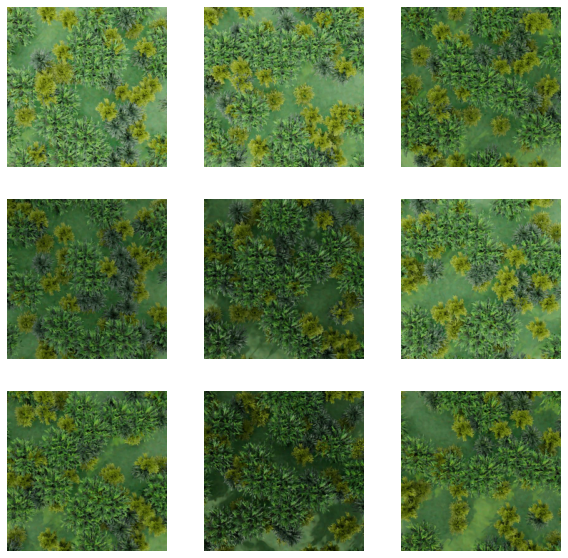

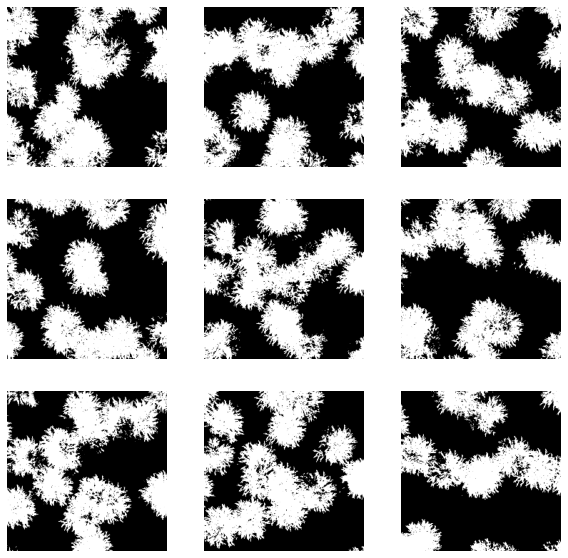

In [11]:

plt.figure(figsize=(10, 10))
for images in train_input_imgs.take(9):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    #plt.title(class_names[labels[i]])
    plt.axis("off")

plt.figure(figsize=(10, 10))
for images in train_target_imgs.take(9):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    #plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
# Applying prefetch 
train_dataset = train_dataset.shuffle(buffer_size= 1000).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

train_dataset , val_dataset

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 3)), types: (tf.float32, tf.float32)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 3)), types: (tf.float32, tf.float32)>)

In [14]:
# Compiling the model 
model.compile(loss = tf.keras.losses.MSE, 
              optimizer = tf.keras.optimizers.Adam() , 
              metrics = ['mse'])

In [ ]:
model.fit(train_dataset ,
          steps_per_epoch = len(train_dataset) ,
          epochs = 100 , 
          validation_data = val_dataset , 
          validation_steps = int(0.15 * len(val_dataset)) ,
          verbose = 2)

Epoch 1/100
125/125 - 63s - loss: 25014.0879 - mse: 25014.0918 - val_loss: 25157.3418 - val_mse: 25157.3418
Epoch 2/100
125/125 - 63s - loss: 25014.0898 - mse: 25014.0938 - val_loss: 25173.9062 - val_mse: 25173.9062
Epoch 3/100
125/125 - 63s - loss: 25014.0898 - mse: 25014.0859 - val_loss: 24991.4844 - val_mse: 24991.4824
Epoch 4/100
125/125 - 64s - loss: 25014.0859 - mse: 25014.0918 - val_loss: 25062.2168 - val_mse: 25062.2168
Epoch 5/100
125/125 - 64s - loss: 25014.0898 - mse: 25014.0918 - val_loss: 24687.5156 - val_mse: 24687.5156
Epoch 6/100
125/125 - 63s - loss: 25014.0859 - mse: 25014.0918 - val_loss: 25373.5391 - val_mse: 25373.5410
Epoch 7/100
125/125 - 64s - loss: 25014.0977 - mse: 25014.0918 - val_loss: 24954.6055 - val_mse: 24954.6055
Epoch 8/100
125/125 - 64s - loss: 25014.0957 - mse: 25014.0977 - val_loss: 25084.1875 - val_mse: 25084.1895
Epoch 9/100
125/125 - 64s - loss: 25014.0898 - mse: 25014.0918 - val_loss: 25152.8203 - val_mse: 25152.8223
Epoch 10/100
125/125 - 63s -

In [40]:
int(0.15 * len(train_dataset)) 

18

In [30]:
import tensorflow_hub as hub 
unet = hub.KerasLayer('https://tfhub.dev/nvidia/unet/industrial/class_6/1' , 
                      input_shape = (224 , 224 , 3))

In [ ]:
unet_model = tf.keras.Sequential([
  unet, 
  layers.Dense(1 , activation='sigmoid')
])

unet_model.summary()